In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("/jet/prs/workspace/rxrx1-utils")
from rxrx import io as rio

import settings_model

In [33]:
import preprocess_data
data = preprocess_data.rxrx_all()

Loading metadata...
Metadata shape: (125510, 10)
81224 values in ids_train
81224 values in labels_train
24 values in ids_train_debug
24 values in labels_train_debug
4492 values in ids_valid
4492 values in labels_valid
24 values in ids_valid_debug
24 values in labels_valid_debug
39794 values in ids_test
39794 values in labels_test
Total ids: 125558.0
Calculating normalization factors by experiment...


In [34]:
import dataset_generator
datasets, loaders = dataset_generator.create_datasets_and_loaders(data, settings_model.batch_size, 
                                                                  settings_model.basepath_data, 
                                                                  settings_model.original_image_size)

Image batch size: torch.Size([32, 6, 128, 128]). Label batch size: 32.
Average pixel value in batch: 0.27051
Stddev pixel value in batch: 1.18947


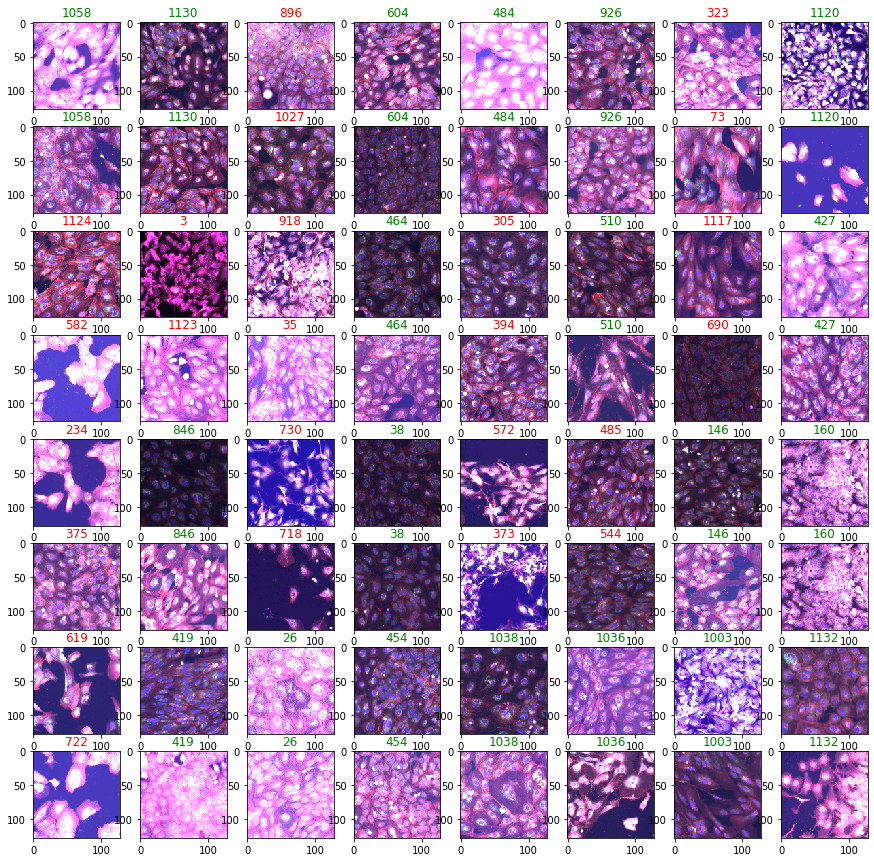

Image batch size: torch.Size([32, 6, 128, 128]). Label batch size: 32.
Average pixel value in batch: 0.19832
Stddev pixel value in batch: 1.06789


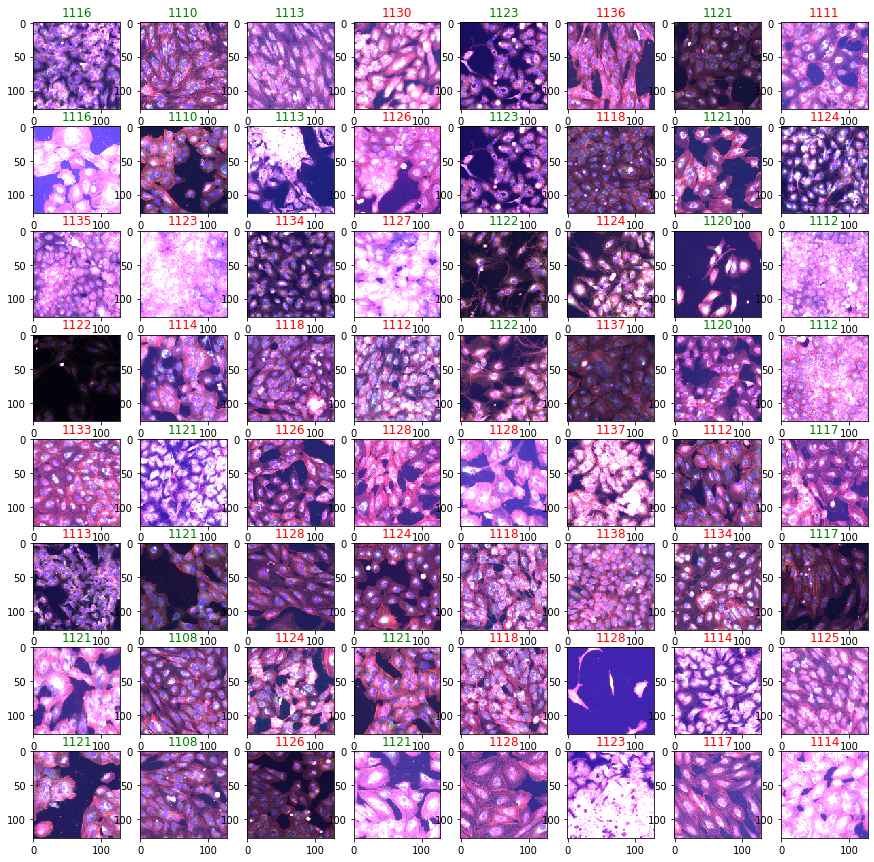

In [35]:
dataset_generator.show_batch(loaders["train"])    
dataset_generator.show_batch(loaders["valid"])

In [36]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [37]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, is_diff):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-is_diff) * torch.pow(euclidean_distance, 2) +
                                      (is_diff) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [7]:
# class WChi2Loss(torch.nn.Module):
#     """
#     Weighted Chi Squared Loss.
#     Based on: https://zpascal.net/cvpr2014/Taigman_DeepFace_Closing_the_2014_CVPR_paper.pdf
#     """

#     def __init__(self, margin=2.0):
#         super(WChi2Loss, self).__init__()
# #         self.margin = margin

#     def forward(self, output1, output2, label):
# #         euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
# #         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
# #                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

#         return None

In [8]:
# class SimpleEucliDistLoss(torch.nn.Module):
#     """
#     Simple Euclidean Distance Loss.
#     """

#     def __init__(self, margin=2.0):
#         super(SimpleEucliDistLoss, self).__init__()
# #         self.margin = margin

#     def forward(self, output1, output2, label):
#         sig = nn.Sigmoid()
#         euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
#         loss = torch.mean(torch.pow(euclidean_distance, 2))
# #         loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
# #                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

#         return (loss)        
# #         return sig(loss)

In [16]:
# class CosSimilLoss(torch.nn.Module):
#     """
#     Simple Cosine Similarity Loss.
#     """

#     def __init__(self, margin=2.0):
#         super(CosSimilLoss, self).__init__()

#     def forward(self, output1, output2, label):
#         print(output1.size(), output2.size(), label.size())
#         print(output1, output2, label)
#         stoppp
#         loss = torch.mean(F.cosine_similarity(output1, output2))

#         return loss

In [21]:
# import numpy as np
# input1 = torch.tensor(np.array([[0,0,0],[0,0,0]], dtype="float"))
# input2 = torch.tensor(np.array([[0,0,0],[0,0,0]], dtype="float"))
# cos = nn.CosineSimilarity(dim=0, eps=1e-6)
# cos(input1, input2)

tensor([0., 0., 0.], dtype=torch.float64)

In [23]:
# input1[:, 0]

tensor([0., 0.], dtype=torch.float64)

In [12]:
# torch.tensor(np.array([[0,0,0],[0.2,0.5,0.9]], dtype="float"))

tensor([[0.0000, 0.0000, 0.0000],
        [0.2000, 0.5000, 0.9000]], dtype=torch.float64)

In [63]:
from matplotlib import pyplot as plt

def plot_histories(histories):
    plt.plot(range(len(histories['loss train'])), histories['loss train'], 
             color='k', label='loss train', alpha=0.5)
    plt.plot(range(len(histories['loss avg train'])), histories['loss avg train'], 
             color='r', ls='dashed', label='loss avg train')
#     plt.plot(range(len(histories['loss validation'])), histories['loss validation'], 
#              color='g', label='loss validation')
    plt.legend()
    plt.show()
    
    plt.plot(range(len(histories['accuracy train'])), histories['accuracy train'], 
             color='k', label='accuracy train', alpha=0.5)
    plt.plot(range(len(histories['accuracy avg train'])), histories['accuracy avg train'], 
             color='r', ls='dashed', label='accuracy avg train')
#     plt.plot(range(len(histories['loss validation'])), histories['loss validation'], 
#              color='g', label='loss validation')
    plt.legend()
    plt.show()
        

In [64]:
import time
from torch import optim
from architecture import siamese_resnet18
from utils import RunningAverage

- Training on 2539 batches of 32 images each.
    Ep [0] It [0/2539] loss: 4.9649305 acc: 0.5000000 avg loss: 4.9649305 avg acc: 0.5000000 160/1.08 imgs/sec
    Ep [0] It [5/2539] loss: 4.4843225 acc: 0.5625000 avg loss: 4.2760387 avg acc: 0.5312500 160/0.43 imgs/sec
    Ep [0] It [10/2539] loss: 2.6492219 acc: 0.5312500 avg loss: 3.8232457 avg acc: 0.5312500 160/0.38 imgs/sec
    Ep [0] It [15/2539] loss: 2.9850600 acc: 0.3750000 avg loss: 3.5184230 avg acc: 0.4921875 160/0.41 imgs/sec
    Ep [0] It [20/2539] loss: 1.7290363 acc: 0.5937500 avg loss: 3.1957114 avg acc: 0.5125000 160/0.37 imgs/sec
    Ep [0] It [25/2539] loss: 2.6690617 acc: 0.4062500 avg loss: 3.0990880 avg acc: 0.4947917 160/0.41 imgs/sec
    Ep [0] It [30/2539] loss: 1.7851295 acc: 0.5937500 avg loss: 2.9547658 avg acc: 0.5089286 160/0.40 imgs/sec
    Ep [0] It [35/2539] loss: 1.9928051 acc: 0.5312500 avg loss: 2.7992016 avg acc: 0.5117188 160/0.42 imgs/sec
    Ep [0] It [40/2539] loss: 1.9018693 acc: 0.5312500 avg l

    Ep [0] It [365/2539] loss: 1.5693094 acc: 0.4375000 avg loss: 1.7628353 avg acc: 0.5211149 160/0.40 imgs/sec
    Ep [0] It [370/2539] loss: 1.0741231 acc: 0.6250000 avg loss: 1.7562249 avg acc: 0.5225000 160/0.40 imgs/sec
    Ep [0] It [375/2539] loss: 1.4600301 acc: 0.4687500 avg loss: 1.7510670 avg acc: 0.5217928 160/0.41 imgs/sec
    Ep [0] It [380/2539] loss: 0.9276544 acc: 0.6875000 avg loss: 1.7455694 avg acc: 0.5239448 160/0.40 imgs/sec
    Ep [0] It [385/2539] loss: 1.4196539 acc: 0.5000000 avg loss: 1.7406386 avg acc: 0.5236378 160/0.40 imgs/sec
    Ep [0] It [390/2539] loss: 1.4801831 acc: 0.4062500 avg loss: 1.7370916 avg acc: 0.5221519 160/0.40 imgs/sec
    Ep [0] It [395/2539] loss: 1.6583352 acc: 0.3750000 avg loss: 1.7334153 avg acc: 0.5203125 160/0.41 imgs/sec
    Ep [0] It [400/2539] loss: 1.2503424 acc: 0.5625000 avg loss: 1.7275000 avg acc: 0.5208333 160/0.40 imgs/sec
    Ep [0] It [405/2539] loss: 1.1152251 acc: 0.5937500 avg loss: 1.7204945 avg acc: 0.5217226 1

    Ep [0] It [730/2539] loss: 1.2196550 acc: 0.5312500 avg loss: 1.4784302 avg acc: 0.5099915 160/0.40 imgs/sec
    Ep [0] It [735/2539] loss: 1.0155659 acc: 0.5000000 avg loss: 1.4759371 avg acc: 0.5099240 160/0.46 imgs/sec
    Ep [0] It [740/2539] loss: 1.0798182 acc: 0.4687500 avg loss: 1.4731652 avg acc: 0.5096477 160/0.37 imgs/sec
    Ep [0] It [745/2539] loss: 1.1145824 acc: 0.6250000 avg loss: 1.4708702 avg acc: 0.5104167 160/0.42 imgs/sec
    Ep [0] It [750/2539] loss: 1.0663047 acc: 0.5625000 avg loss: 1.4682402 avg acc: 0.5107616 160/0.44 imgs/sec
    Ep [0] It [755/2539] loss: 1.0401158 acc: 0.5312500 avg loss: 1.4658329 avg acc: 0.5108964 160/0.43 imgs/sec
    Ep [0] It [760/2539] loss: 1.0969753 acc: 0.5312500 avg loss: 1.4635098 avg acc: 0.5110294 160/0.39 imgs/sec
    Ep [0] It [765/2539] loss: 1.0569549 acc: 0.5000000 avg loss: 1.4608537 avg acc: 0.5109578 160/0.42 imgs/sec
    Ep [0] It [770/2539] loss: 1.0758598 acc: 0.5000000 avg loss: 1.4582192 avg acc: 0.5108871 1

    Ep [0] It [1095/2539] loss: 1.0688825 acc: 0.4687500 avg loss: 1.3404881 avg acc: 0.5110795 160/0.42 imgs/sec
    Ep [0] It [1100/2539] loss: 1.0447404 acc: 0.7187500 avg loss: 1.3389475 avg acc: 0.5120192 160/0.44 imgs/sec
    Ep [0] It [1105/2539] loss: 1.0257502 acc: 0.5937500 avg loss: 1.3375959 avg acc: 0.5123874 160/0.44 imgs/sec
    Ep [0] It [1110/2539] loss: 1.0227695 acc: 0.5000000 avg loss: 1.3362473 avg acc: 0.5123318 160/0.39 imgs/sec
    Ep [0] It [1115/2539] loss: 1.0346645 acc: 0.5937500 avg loss: 1.3349205 avg acc: 0.5126953 160/0.43 imgs/sec
    Ep [0] It [1120/2539] loss: 1.0038605 acc: 0.5312500 avg loss: 1.3334943 avg acc: 0.5127778 160/0.43 imgs/sec
    Ep [0] It [1125/2539] loss: 1.0427837 acc: 0.4687500 avg loss: 1.3322398 avg acc: 0.5125830 160/0.42 imgs/sec
    Ep [0] It [1130/2539] loss: 1.0123429 acc: 0.5312500 avg loss: 1.3309147 avg acc: 0.5126652 160/0.39 imgs/sec
    Ep [0] It [1135/2539] loss: 1.0550766 acc: 0.4062500 avg loss: 1.3296158 avg acc: 0.

    Ep [0] It [1455/2539] loss: 1.0271987 acc: 0.5312500 avg loss: 1.2634317 avg acc: 0.5128425 160/0.41 imgs/sec
    Ep [0] It [1460/2539] loss: 1.0125601 acc: 0.5312500 avg loss: 1.2626046 avg acc: 0.5129053 160/0.44 imgs/sec
    Ep [0] It [1465/2539] loss: 1.0496721 acc: 0.4062500 avg loss: 1.2618223 avg acc: 0.5125425 160/0.41 imgs/sec
    Ep [0] It [1470/2539] loss: 1.0505486 acc: 0.5625000 avg loss: 1.2609905 avg acc: 0.5127119 160/0.38 imgs/sec
    Ep [0] It [1475/2539] loss: 0.9990387 acc: 0.5000000 avg loss: 1.2601610 avg acc: 0.5126689 160/0.40 imgs/sec
    Ep [0] It [1480/2539] loss: 1.0176364 acc: 0.6562500 avg loss: 1.2593633 avg acc: 0.5131524 160/0.42 imgs/sec
    Ep [0] It [1485/2539] loss: 1.0093422 acc: 0.4687500 avg loss: 1.2585406 avg acc: 0.5130034 160/0.43 imgs/sec
    Ep [0] It [1490/2539] loss: 1.0200148 acc: 0.4062500 avg loss: 1.2577227 avg acc: 0.5126463 160/0.46 imgs/sec
    Ep [0] It [1495/2539] loss: 1.0167776 acc: 0.5937500 avg loss: 1.2569098 avg acc: 0.

    Ep [0] It [1815/2539] loss: 1.0400909 acc: 0.4375000 avg loss: 1.2148978 avg acc: 0.5124485 160/0.40 imgs/sec
    Ep [0] It [1820/2539] loss: 1.0360721 acc: 0.5625000 avg loss: 1.2143958 avg acc: 0.5125856 160/0.42 imgs/sec
    Ep [0] It [1825/2539] loss: 0.9870423 acc: 0.5625000 avg loss: 1.2138378 avg acc: 0.5127220 160/0.42 imgs/sec
    Ep [0] It [1830/2539] loss: 0.9861110 acc: 0.5937500 avg loss: 1.2132820 avg acc: 0.5129428 160/0.42 imgs/sec
    Ep [0] It [1835/2539] loss: 0.9984136 acc: 0.5000000 avg loss: 1.2127314 avg acc: 0.5129076 160/0.43 imgs/sec
    Ep [0] It [1840/2539] loss: 1.0161710 acc: 0.4687500 avg loss: 1.2121814 avg acc: 0.5127879 160/0.39 imgs/sec
    Ep [0] It [1845/2539] loss: 1.0173929 acc: 0.3125000 avg loss: 1.2116562 avg acc: 0.5122466 160/0.44 imgs/sec
    Ep [0] It [1850/2539] loss: 1.0240166 acc: 0.5000000 avg loss: 1.2111473 avg acc: 0.5122136 160/0.42 imgs/sec
    Ep [0] It [1855/2539] loss: 1.0157584 acc: 0.5625000 avg loss: 1.2106375 avg acc: 0.

    Ep [0] It [2175/2539] loss: 1.0207622 acc: 0.5000000 avg loss: 1.1820019 avg acc: 0.5112529 160/0.41 imgs/sec
    Ep [0] It [2180/2539] loss: 1.0184964 acc: 0.4375000 avg loss: 1.1816184 avg acc: 0.5110841 160/0.41 imgs/sec
    Ep [0] It [2185/2539] loss: 1.0111890 acc: 0.5000000 avg loss: 1.1812235 avg acc: 0.5110588 160/0.41 imgs/sec
    Ep [0] It [2190/2539] loss: 1.0236688 acc: 0.6875000 avg loss: 1.1808188 avg acc: 0.5114607 160/0.44 imgs/sec
    Ep [0] It [2195/2539] loss: 1.0002427 acc: 0.5625000 avg loss: 1.1804544 avg acc: 0.5115767 160/0.41 imgs/sec
    Ep [0] It [2200/2539] loss: 1.0116851 acc: 0.4375000 avg loss: 1.1800914 avg acc: 0.5114087 160/0.43 imgs/sec
    Ep [0] It [2205/2539] loss: 1.0206840 acc: 0.4375000 avg loss: 1.1797308 avg acc: 0.5112415 160/0.40 imgs/sec
    Ep [0] It [2210/2539] loss: 0.9986044 acc: 0.5625000 avg loss: 1.1793868 avg acc: 0.5113572 160/0.42 imgs/sec
    Ep [0] It [2215/2539] loss: 1.0104139 acc: 0.4062500 avg loss: 1.1790189 avg acc: 0.

    Ep [0] It [2535/2539] loss: 1.0142646 acc: 0.5000000 avg loss: 1.1579524 avg acc: 0.5121801 160/0.28 imgs/sec
- Train epoch metrics summary: average loss: 1.1577793 ;  average accuracy: 0.5121801 ;  
  Training run in 212.61 seconds.


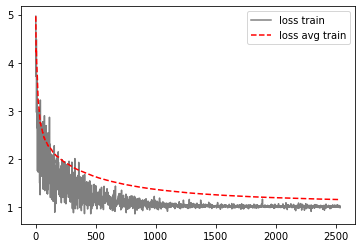

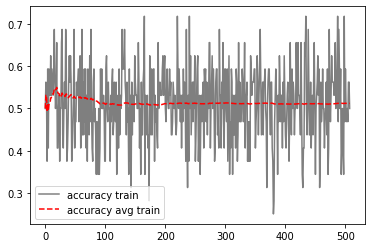

- Training on 2539 batches of 32 images each.
    Ep [1] It [0/2539] loss: 1.0100445 acc: 0.4062500 avg loss: 1.1577212 avg acc: 0.5119720 160/1.78 imgs/sec
    Ep [1] It [5/2539] loss: 1.0061750 acc: 0.4375000 avg loss: 1.1574687 avg acc: 0.5118260 160/0.45 imgs/sec
    Ep [1] It [10/2539] loss: 1.0083132 acc: 0.4375000 avg loss: 1.1571756 avg acc: 0.5116805 160/0.42 imgs/sec
    Ep [1] It [15/2539] loss: 1.0156208 acc: 0.4687500 avg loss: 1.1568876 avg acc: 0.5115967 160/0.41 imgs/sec
    Ep [1] It [20/2539] loss: 0.9951044 acc: 0.5625000 avg loss: 1.1565912 avg acc: 0.5116959 160/0.40 imgs/sec
    Ep [1] It [25/2539] loss: 1.0119739 acc: 0.5937500 avg loss: 1.1563050 avg acc: 0.5118555 160/0.39 imgs/sec
    Ep [1] It [30/2539] loss: 1.0197932 acc: 0.6250000 avg loss: 1.1560196 avg acc: 0.5120752 160/0.42 imgs/sec
    Ep [1] It [35/2539] loss: 1.0278981 acc: 0.4687500 avg loss: 1.1557416 avg acc: 0.5119913 160/0.39 imgs/sec
    Ep [1] It [40/2539] loss: 1.0157903 acc: 0.4375000 avg l

    Ep [1] It [365/2539] loss: 1.0215163 acc: 0.4687500 avg loss: 1.1393672 avg acc: 0.5106314 160/0.44 imgs/sec
    Ep [1] It [370/2539] loss: 1.0022151 acc: 0.4687500 avg loss: 1.1391666 avg acc: 0.5105596 160/0.40 imgs/sec
    Ep [1] It [375/2539] loss: 1.0128872 acc: 0.5625000 avg loss: 1.1389467 avg acc: 0.5106485 160/0.45 imgs/sec
    Ep [1] It [380/2539] loss: 1.0069230 acc: 0.4062500 avg loss: 1.1387325 avg acc: 0.5104701 160/0.40 imgs/sec
    Ep [1] It [385/2539] loss: 1.0438380 acc: 0.3750000 avg loss: 1.1385278 avg acc: 0.5102389 160/0.42 imgs/sec
    Ep [1] It [390/2539] loss: 1.0094894 acc: 0.4375000 avg loss: 1.1383138 avg acc: 0.5101150 160/0.40 imgs/sec
    Ep [1] It [395/2539] loss: 0.9976389 acc: 0.4687500 avg loss: 1.1380840 avg acc: 0.5100446 160/0.45 imgs/sec
    Ep [1] It [400/2539] loss: 0.9969631 acc: 0.5000000 avg loss: 1.1378799 avg acc: 0.5100276 160/0.40 imgs/sec
    Ep [1] It [405/2539] loss: 1.0098600 acc: 0.5000000 avg loss: 1.1376700 avg acc: 0.5100106 1

    Ep [1] It [730/2539] loss: 1.0039502 acc: 0.5312500 avg loss: 1.1248824 avg acc: 0.5102099 160/0.44 imgs/sec
    Ep [1] It [735/2539] loss: 1.0880305 acc: 0.3125000 avg loss: 1.1247606 avg acc: 0.5099085 160/0.42 imgs/sec
    Ep [1] It [740/2539] loss: 1.0224075 acc: 0.4687500 avg loss: 1.1245858 avg acc: 0.5098459 160/0.40 imgs/sec
    Ep [1] It [745/2539] loss: 1.0053117 acc: 0.5312500 avg loss: 1.1244141 avg acc: 0.5098784 160/0.41 imgs/sec
    Ep [1] It [750/2539] loss: 1.0076160 acc: 0.4375000 avg loss: 1.1242340 avg acc: 0.5097686 160/0.43 imgs/sec
    Ep [1] It [755/2539] loss: 0.9997401 acc: 0.5937500 avg loss: 1.1240570 avg acc: 0.5098958 160/0.44 imgs/sec
    Ep [1] It [760/2539] loss: 1.0156200 acc: 0.4687500 avg loss: 1.1238879 avg acc: 0.5098336 160/0.40 imgs/sec
    Ep [1] It [765/2539] loss: 0.9824651 acc: 0.5625000 avg loss: 1.1237096 avg acc: 0.5099131 160/0.41 imgs/sec
    Ep [1] It [770/2539] loss: 0.9956606 acc: 0.4687500 avg loss: 1.1235430 avg acc: 0.5098511 1

    Ep [1] It [1095/2539] loss: 1.0236615 acc: 0.4375000 avg loss: 1.1134829 avg acc: 0.5105168 160/0.41 imgs/sec
    Ep [1] It [1100/2539] loss: 1.0298665 acc: 0.4687500 avg loss: 1.1133460 avg acc: 0.5104595 160/0.44 imgs/sec
    Ep [1] It [1105/2539] loss: 1.0203288 acc: 0.4687500 avg loss: 1.1131970 avg acc: 0.5104024 160/0.40 imgs/sec
    Ep [1] It [1110/2539] loss: 1.0169272 acc: 0.5625000 avg loss: 1.1130552 avg acc: 0.5104737 160/0.42 imgs/sec
    Ep [1] It [1115/2539] loss: 0.9659694 acc: 0.5625000 avg loss: 1.1129026 avg acc: 0.5105447 160/0.44 imgs/sec
    Ep [1] It [1120/2539] loss: 0.9972216 acc: 0.5625000 avg loss: 1.1127592 avg acc: 0.5106156 160/0.38 imgs/sec
    Ep [1] It [1125/2539] loss: 1.0150253 acc: 0.4687500 avg loss: 1.1126268 avg acc: 0.5105586 160/0.44 imgs/sec
    Ep [1] It [1130/2539] loss: 1.0051764 acc: 0.5000000 avg loss: 1.1125082 avg acc: 0.5105442 160/0.41 imgs/sec
    Ep [1] It [1135/2539] loss: 1.0077578 acc: 0.5937500 avg loss: 1.1123675 avg acc: 0.

    Ep [1] It [1455/2539] loss: 1.0150101 acc: 0.4375000 avg loss: 1.1041626 avg acc: 0.5093359 160/0.41 imgs/sec
    Ep [1] It [1460/2539] loss: 1.0054743 acc: 0.4375000 avg loss: 1.1040342 avg acc: 0.5092463 160/0.44 imgs/sec
    Ep [1] It [1465/2539] loss: 1.0401219 acc: 0.6250000 avg loss: 1.1039269 avg acc: 0.5093906 160/0.41 imgs/sec
    Ep [1] It [1470/2539] loss: 1.0045633 acc: 0.4687500 avg loss: 1.1037996 avg acc: 0.5093400 160/0.39 imgs/sec
    Ep [1] It [1475/2539] loss: 1.0754528 acc: 0.2812500 avg loss: 1.1037103 avg acc: 0.5090563 160/0.41 imgs/sec
    Ep [1] It [1480/2539] loss: 0.9944985 acc: 0.4062500 avg loss: 1.1035813 avg acc: 0.5089286 160/0.44 imgs/sec
    Ep [1] It [1485/2539] loss: 1.0002072 acc: 0.5000000 avg loss: 1.1034618 avg acc: 0.5089175 160/0.40 imgs/sec
    Ep [1] It [1490/2539] loss: 1.0299644 acc: 0.4062500 avg loss: 1.1033491 avg acc: 0.5087903 160/0.41 imgs/sec
    Ep [1] It [1495/2539] loss: 1.0481786 acc: 0.3437500 avg loss: 1.1032470 avg acc: 0.

    Ep [1] It [1815/2539] loss: 0.9887406 acc: 0.5625000 avg loss: 1.0963895 avg acc: 0.5085651 160/0.42 imgs/sec
    Ep [1] It [1820/2539] loss: 1.0034013 acc: 0.5937500 avg loss: 1.0962824 avg acc: 0.5086627 160/0.37 imgs/sec
    Ep [1] It [1825/2539] loss: 1.0026239 acc: 0.6250000 avg loss: 1.0961826 avg acc: 0.5087958 160/0.42 imgs/sec
    Ep [1] It [1830/2539] loss: 1.0249002 acc: 0.5312500 avg loss: 1.0960888 avg acc: 0.5088214 160/0.43 imgs/sec
    Ep [1] It [1835/2539] loss: 1.0110745 acc: 0.4062500 avg loss: 1.0959998 avg acc: 0.5087043 160/0.44 imgs/sec
    Ep [1] It [1840/2539] loss: 1.0050440 acc: 0.5000000 avg loss: 1.0959045 avg acc: 0.5086944 160/0.40 imgs/sec
    Ep [1] It [1845/2539] loss: 1.0246100 acc: 0.4062500 avg loss: 1.0958206 avg acc: 0.5085777 160/0.45 imgs/sec
    Ep [1] It [1850/2539] loss: 1.0169528 acc: 0.4687500 avg loss: 1.0957220 avg acc: 0.5085324 160/0.39 imgs/sec
    Ep [1] It [1855/2539] loss: 1.0160806 acc: 0.4687500 avg loss: 1.0956223 avg acc: 0.

    Ep [1] It [2175/2539] loss: 1.0065745 acc: 0.5937500 avg loss: 1.0897597 avg acc: 0.5092360 160/0.41 imgs/sec
    Ep [1] It [2180/2539] loss: 1.0065234 acc: 0.4375000 avg loss: 1.0896751 avg acc: 0.5091601 160/0.41 imgs/sec
    Ep [1] It [2185/2539] loss: 1.0050492 acc: 0.5000000 avg loss: 1.0895948 avg acc: 0.5091504 160/0.41 imgs/sec
    Ep [1] It [2190/2539] loss: 1.0110185 acc: 0.4375000 avg loss: 1.0895168 avg acc: 0.5090747 160/0.43 imgs/sec
    Ep [1] It [2195/2539] loss: 0.9970286 acc: 0.5937500 avg loss: 1.0894228 avg acc: 0.5091640 160/0.41 imgs/sec
    Ep [1] It [2200/2539] loss: 1.0109421 acc: 0.4062500 avg loss: 1.0893486 avg acc: 0.5090556 160/0.40 imgs/sec
    Ep [1] It [2205/2539] loss: 1.0085707 acc: 0.4375000 avg loss: 1.0892627 avg acc: 0.5089803 160/0.42 imgs/sec
    Ep [1] It [2210/2539] loss: 1.0217390 acc: 0.5625000 avg loss: 1.0891694 avg acc: 0.5090365 160/0.42 imgs/sec
    Ep [1] It [2215/2539] loss: 1.0087688 acc: 0.7187500 avg loss: 1.0890833 avg acc: 0.

    Ep [1] It [2535/2539] loss: 1.0432988 acc: 0.3750000 avg loss: 1.0841082 avg acc: 0.5088583 160/0.28 imgs/sec
- Train epoch metrics summary: average loss: 1.0840575 ;  average accuracy: 0.5088583 ;  
  Training run in 212.36 seconds.


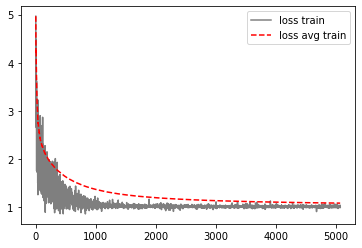

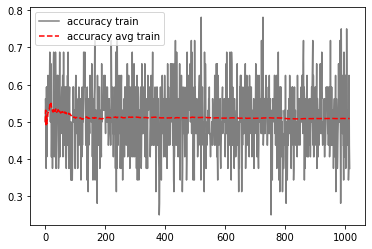

In [67]:
torch.manual_seed(42)

model = siamese_resnet18().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1.e-5)

loss_avg = RunningAverage()
accuracy_avg = RunningAverage()

loss_history = []
loss_avg_history = []
accuracy_history = []
accuracy_avg_history = []
num_steps = int(len(loaders["train"]))
num_epochs = 2
save_summary_steps = 5

# set model to training mode
model.train()

start_abs = time.time()
start = time.time()
for epoch in range(num_epochs):
    # iterate over batches
    print(f'- Training on {num_steps} batches of {settings_model.batch_size} images each.')
    for i, data in enumerate(loaders["train"]):
        if i>num_steps:
            break
        img_batch1, img_batch2, is_diff_batch, label_batch1, label_batch2 = data
        img_batch1 = img_batch1.type(torch.float32).cuda()
        img_batch2 = img_batch2.type(torch.float32).cuda()
        is_diff_batch = is_diff_batch.type(torch.float32).cuda()
        
        optimizer.zero_grad()
        output_batch1, output_batch2 = model(img_batch1, img_batch2)
        loss = criterion(output_batch1, output_batch2, is_diff_batch)
        loss.backward()
        optimizer.step()
        
        loss_avg.update(loss.item())
        loss_history.append(loss.item())
        loss_avg_history.append(loss_avg())
        
        if i%save_summary_steps == 0:
            euclidean_distance = F.pairwise_distance(output_batch1.detach(), 
                output_batch2.detach(), keepdim=True).view(-1).data.cpu().numpy()
            is_diff = is_diff_batch.data.cpu().numpy()
            prediction = (euclidean_distance > 1.).astype("int")
            acc = sum(prediction == is_diff) / len(prediction)
            accuracy_avg.update(acc)
            summary_batch_string = "loss: {:05.7f} ".format(loss.item())
            summary_batch_string += "acc: {:05.7f} ".format(acc)
            summary_batch_string += "avg loss: {:05.7f} ".format(loss_avg())
            summary_batch_string += "avg acc: {:05.7f} ".format(accuracy_avg())
            summary_batch_string += "{}/{:.2f} imgs/sec"\
                .format(save_summary_steps*settings_model.batch_size, 
                        time.time() - start)
            print('    Ep [{}] It [{}/{}] '.\
                  format(epoch, i, num_steps) + summary_batch_string)
            accuracy_history.append(acc)
            accuracy_avg_history.append(accuracy_avg())
            start = time.time() # reset clock
    
    # log epoch summary
    metrics_string = "average loss: {:05.7f} ;  ".format(loss_avg())
    metrics_string += "average accuracy: {:05.7f} ;  ".format(accuracy_avg())
    print("- Train epoch metrics summary: " + metrics_string)
    print('  Training run in {:.2f} seconds.'.format(time.time() - start_abs))
    
    # show epoch on epoch results
    histories = {"loss train" : loss_history,
                 "loss avg train" : loss_avg_history,
                 "accuracy train" : accuracy_history,
                 "accuracy avg train" : accuracy_avg_history}
    plot_histories(histories)
    
    start_abs = time.time() # reset clock
    

In [27]:
# set model to evaluation mode
model.eval()
losses = []

start = time.time()

num_steps = 1000

is_diff_batch_list, euclidean_distance_list = [], []

with torch.no_grad():
    for i, data in enumerate(loaders["valid"]):
        if i>num_steps:
            break
        img_batch1, img_batch2, is_diff_batch, label_batch1, label_batch2 = data
        img_batch1, img_batch2 = img_batch1.type(torch.float32).cuda(), img_batch2.type(torch.float32).cuda()
        is_diff_batch = is_diff_batch.type(torch.float32).cuda()
        # compute model output
        output_batch1, output_batch2 = model(img_batch1, img_batch2)
        # compute loss of batch
        loss = criterion(output_batch1, output_batch2, is_diff_batch)
        losses.append(loss.item())
        # compute euclidean distance
        euclidean_distance = F.pairwise_distance(output_batch1, output_batch2, keepdim=True).view(-1)
        is_diff_batch_list += is_diff_batch.data.cpu().numpy().tolist()
        euclidean_distance_list += euclidean_distance.data.cpu().numpy().tolist()
    # compute mean of all metrics in summary
    metrics_mean = {'loss' : np.nanmean(losses)}
    metrics_string = "average loss = {:05.7f} ;  ".format(metrics_mean['loss'])
    print("- Eval metrics : " + metrics_string)
    print('  Evaluation run in {:.2f} seconds.'.format(time.time() - start))

euclidean_distance = np.array(euclidean_distance_list)
is_diff_batch = np.array(is_diff_batch_list)

- Eval metrics : average loss = 3.2845502 ;  
  Evaluation run in 6.12 seconds.


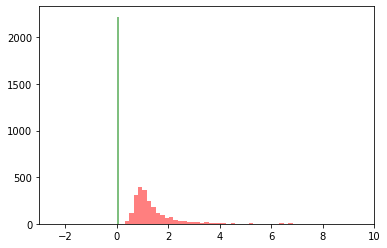

In [31]:
import numpy as np
diff = euclidean_distance - is_diff_batch
fig, ax = plt.subplots()
plt.hist(diff[is_diff_batch==1], color="red", bins=200, alpha=0.5)
plt.hist(diff[is_diff_batch==0], color="green", alpha=0.5)
plt.xlim([-3, 10])
plt.show()